In [1]:
!pip install contextily

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 1.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install geopandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 2.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors
import contextily as ctx

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


# Read data

In [4]:
# read datasets
yellow_1 = pd.read_parquet('yellow_tripdata_2019-01.parquet')
yellow_4 = pd.read_parquet('yellow_tripdata_2019-04.parquet')
yellow_7 = pd.read_parquet('yellow_tripdata_2019-07.parquet')
yellow_10 = pd.read_parquet('yellow_tripdata_2019-10.parquet')
# combine the monthly data 
data = pd.concat([yellow_1, yellow_4, yellow_7, yellow_10]).reset_index(drop=True)

# save memory
del yellow_1
del yellow_4
del yellow_7
del yellow_10

In [5]:
nyc_temp = pd.read_csv("nyc_temperature.csv", sep = ',')

In [6]:
nyc_temp.head()

,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth
0,1/1/19,60,40,50.0,13.9,15,0,0.08,0,0
1,2/1/19,41,35,38.0,2.1,27,0,0,0,0
2,3/1/19,45,39,42.0,6.3,23,0,T,0,0
3,4/1/19,47,37,42.0,6.5,23,0,0,0,0
4,5/1/19,47,42,44.5,9.1,20,0,0.45,0,0


In [7]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN,None
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN,None
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,None
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN,None
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN,None


# Prepocessing

In [8]:
def F2C(x):
    return (x-32)*(5/9)

nyc_temp["date"] =  pd.to_datetime(nyc_temp["date"], format='%d/%m/%y')
nyc_temp["tmax_c"] = nyc_temp["tmax"].apply(F2C)
nyc_temp["tmin_c"] = nyc_temp["tmin"].apply(F2C)
nyc_temp["tavg_c"] = nyc_temp["tavg"].apply(F2C)
nyc_temp["departure_c"] = nyc_temp["departure"].apply(F2C)
nyc_temp["precipitation"].replace(to_replace="T", value=0, inplace = True)
nyc_temp["new_snow"].replace(to_replace="T", value=0, inplace = True)
nyc_temp["snow_depth"].replace(to_replace="T", value=0, inplace = True)
nyc_temp.head()

,date,tmax,tmin,tavg,departure,HDD,CDD,precipitation,new_snow,snow_depth,tmax_c,tmin_c,tavg_c,departure_c
0,2019-01-01,60,40,50.0,13.9,15,0,0.08,0,0,15.555556,4.444444,10.000000,-10.055556
1,2019-01-02,41,35,38.0,2.1,27,0,0,0,0,5.000000,1.666667,3.333333,-16.611111
2,2019-01-03,45,39,42.0,6.3,23,0,0,0,0,7.222222,3.888889,5.555556,-14.277778
3,2019-01-04,47,37,42.0,6.5,23,0,0,0,0,8.333333,2.777778,5.555556,-14.166667
4,2019-01-05,47,42,44.5,9.1,20,0,0.45,0,0,8.333333,5.555556,6.944444,-12.722222


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28696876 entries, 0 to 28696875
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee         

In [10]:
# reduce memory
float_cols = [c for c in data if data[c].dtype == "float64"]
int_cols = [c for c in data if data[c].dtype in ["int64"]]
c_cols = [c for c in data if data[c].dtype in ["object"]]
data[float_cols] = data[float_cols].astype(np.float16)
data[int_cols] = data[int_cols].astype(np.int16)
data[c_cols] = data[c_cols].astype('category')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28696876 entries, 0 to 28696875
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int16         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float16       
 4   trip_distance          float16       
 5   RatecodeID             float16       
 6   store_and_fwd_flag     category      
 7   PULocationID           int16         
 8   DOLocationID           int16         
 9   payment_type           int16         
 10  fare_amount            float16       
 11  extra                  float16       
 12  mta_tax                float16       
 13  tip_amount             float16       
 14  tolls_amount           float16       
 15  improvement_surcharge  float16       
 16  total_amount           float16       
 17  congestion_surcharge   float16       
 18  airport_fee         

In [12]:
nyc_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           365 non-null    datetime64[ns]
 1   tmax           365 non-null    int64         
 2   tmin           365 non-null    int64         
 3   tavg           365 non-null    float64       
 4   departure      365 non-null    float64       
 5   HDD            365 non-null    int64         
 6   CDD            365 non-null    int64         
 7   precipitation  365 non-null    object        
 8   new_snow       365 non-null    object        
 9   snow_depth     365 non-null    object        
 10  tmax_c         365 non-null    float64       
 11  tmin_c         365 non-null    float64       
 12  tavg_c         365 non-null    float64       
 13  departure_c    365 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(4), object(3)
memory usage: 40.0+ 

In [13]:
# reduce memory
float_cols = [c for c in nyc_temp if nyc_temp[c].dtype == "float64"]
int_cols = [c for c in nyc_temp if nyc_temp[c].dtype in ["int64"]]
c_cols = [c for c in nyc_temp if nyc_temp[c].dtype in ["object"]]
nyc_temp[float_cols] = nyc_temp[float_cols].astype(np.float16)
nyc_temp[int_cols] = nyc_temp[int_cols].astype(np.int16)
nyc_temp[c_cols] = nyc_temp[c_cols].astype('category')

In [14]:
nyc_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           365 non-null    datetime64[ns]
 1   tmax           365 non-null    int16         
 2   tmin           365 non-null    int16         
 3   tavg           365 non-null    float16       
 4   departure      365 non-null    float16       
 5   HDD            365 non-null    int16         
 6   CDD            365 non-null    int16         
 7   precipitation  365 non-null    category      
 8   new_snow       365 non-null    category      
 9   snow_depth     365 non-null    category      
 10  tmax_c         365 non-null    float16       
 11  tmin_c         365 non-null    float16       
 12  tavg_c         365 non-null    float16       
 13  departure_c    365 non-null    float16       
dtypes: category(3), datetime64[ns](1), float16(6), int16(4)
memory usage: 15.2

# Data Clean

In [15]:
# Check the nan value
for c in data.columns:
    print(f'{c} nan value count: {np.sum(data[c].isnull())}')

VendorID nan value count: 0
tpep_pickup_datetime nan value count: 0
tpep_dropoff_datetime nan value count: 0
passenger_count nan value count: 151810
trip_distance nan value count: 0
RatecodeID nan value count: 151810
store_and_fwd_flag nan value count: 151810
PULocationID nan value count: 0
DOLocationID nan value count: 0
payment_type nan value count: 0
fare_amount nan value count: 0
extra nan value count: 0
mta_tax nan value count: 0
tip_amount nan value count: 0
tolls_amount nan value count: 0
improvement_surcharge nan value count: 0
total_amount nan value count: 0
congestion_surcharge nan value count: 5008025
airport_fee nan value count: 28696876


In [16]:
# drop all the missing 

data['passenger_count'].fillna(0, inplace = True) # fill 0
data['RatecodeID'].fillna(data['RatecodeID'].value_counts().idxmax(), inplace = True) # fill most common value
data['congestion_surcharge'].fillna(data['congestion_surcharge'].median(), inplace = True) # fill mediana value
data.drop(columns=['airport_fee'], inplace = True)

# remove_invalid_data

# VendorID
data = data[(data['VendorID'] == 1) | (data['VendorID'] == 2)]

# trip_distance 
data = data[(data['trip_distance'] > 0) & (data['trip_distance'] <= 100)]

# RatecodeID
data = data[(data['RatecodeID'] == 1) | 
        (data['RatecodeID'] == 2) | 
        (data['RatecodeID'] == 3) | 
        (data['RatecodeID'] == 4) | 
        (data['RatecodeID'] == 5) | 
        (data['RatecodeID'] == 6)]

# fare amount
data = data[(data['fare_amount'] >= 0) & 
        (data['fare_amount'] <= 250)]

# extra
data = data[(data['extra'] >= 0)]

# MTA_tax
data = data[(data['mta_tax'] >= 0)]

# trips amount 
data = data[(data['tip_amount'] >= 0)]

# tolls_amount
data = data[(data['tolls_amount'] >= 0)]

# improvement_surcharge
data = data[(data['improvement_surcharge'] >= 0)]

# total_amount
data = data[(data['total_amount'] >= 0)]

# congestion_surcharge
data = data[(data['congestion_surcharge'] >= 0)]

# PU and DO location id not within NYC taxi zone
data = data[(data['PULocationID'] >= 1) & 
        (data['PULocationID'] <= 263) & 
        (data['DOLocationID'] >= 1) & 
        (data['DOLocationID'] <= 263)]


# Data distrubtion

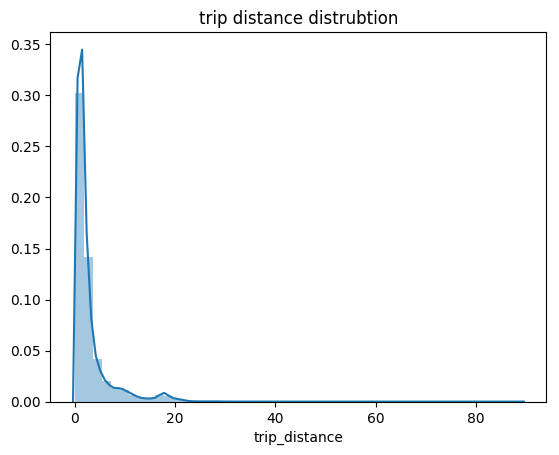

In [17]:
# trip distance
# total_amount
plt.figure()
sns.distplot(data['trip_distance'],kde=True)
plt.title('trip distance distrubtion')
plt.show()

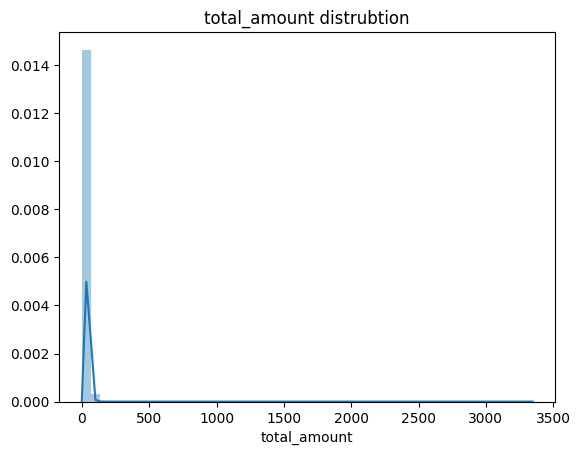

In [18]:
plt.figure()
sns.distplot(data['total_amount'],kde=True)
plt.title('total_amount distrubtion')
plt.show()

# Feature Engineering

In [19]:
# to date time
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
# get date
data['date_time'] = data['tpep_pickup_datetime'].dt.normalize()

# get 
data['period'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']
data['period'] = data['period'] / np.timedelta64(1, 'm')


# drop not interested features
data = data.drop(['tpep_pickup_datetime', 
                'tpep_dropoff_datetime',
                'store_and_fwd_flag'], axis=1)

# period in 3 hours 
data = data[(data['period'] > 0) & 
        (data['period'] <= 180)]


# Identify pickup and dropoff borough
zone_data = pd.read_csv('taxi+_zone_lookup.csv')
data = pd.DataFrame(pd.merge(data, zone_data[['LocationID', 'Borough']], 
                            left_on='PULocationID', 
                            right_on='LocationID')).drop('LocationID', 
                                                            axis=1)
data = data.rename({'Borough':'pick_up_borough'}, axis=1)
data = pd.DataFrame(pd.merge(data, zone_data[['LocationID', 'Borough']], 
                            left_on='DOLocationID', 
                            right_on='LocationID')).drop('LocationID', 
                                                            axis=1)
data = data.rename({'Borough':'dorp_off_borough'}, axis=1)


# Identify pick up and dropoff location thats from airport
data.loc[data['PULocationID'] == 138, 'pick_up_borough'] = 'LaGuardia'
data.loc[data['DOLocationID'] == 138, 'dorp_off_borough'] = 'LaGuardia'

data.loc[data['PULocationID'] == 132, 'pick_up_borough'] = 'JFK'
data.loc[data['DOLocationID'] == 132, 'dorp_off_borough'] = 'JFK'

# get day right
data = data[((data['date_time'] <= '2019-01-31')&
    (data['date_time'] >= '2019-01-01'))|

    ((data['date_time'] <= '2019-04-30')&
    (data['date_time'] >= '2019-04-01'))|

    ((data['date_time'] <= '2019-07-31')&
    (data['date_time'] >= '2019-07-01'))|

    ((data['date_time'] <= '2019-10-31')&
    (data['date_time'] >= '2019-10-01'))]

# get season
data['season'] = 0
# get season
data.loc[(data['date_time'] <= '2019-01-31')& (data['date_time'] >= '2019-01-01'), 'season'] = 'winter'
data.loc[(data['date_time'] <= '2019-04-30')& (data['date_time'] >= '2019-04-01'), 'season'] = 'spring'
data.loc[(data['date_time'] <= '2019-07-31')& (data['date_time'] >= '2019-07-01'), 'season'] = 'summer'
data.loc[(data['date_time'] <= '2019-10-31')& (data['date_time'] >= '2019-10-01'), 'season'] = 'fall'

# Vis

## pick up and drop off

In [20]:
# axi zone shapefile
taxi_zones = gpd.read_file('taxi_zones.shp')
taxi_zones['geometry'] = taxi_zones['geometry'].to_crs('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

In [21]:
# Compute pickup and dropoff amount of each zone
pick_up_zone = data.groupby(['PULocationID'], as_index=False).size()
dorp_off_zone = data.groupby(['DOLocationID'], as_index=False).size()
pick_up_zone = gpd.GeoDataFrame(pd.merge(pick_up_zone, 
                                         taxi_zones, 
                                         left_on='PULocationID', 
                                         right_on='LocationID')).drop('LocationID', axis=1).to_crs(epsg=3857)
dorp_off_zone = gpd.GeoDataFrame(pd.merge(dorp_off_zone, 
                                          taxi_zones, 
                                          left_on='DOLocationID', 
                                          right_on='LocationID')).drop('LocationID', axis=1).to_crs(epsg=3857)


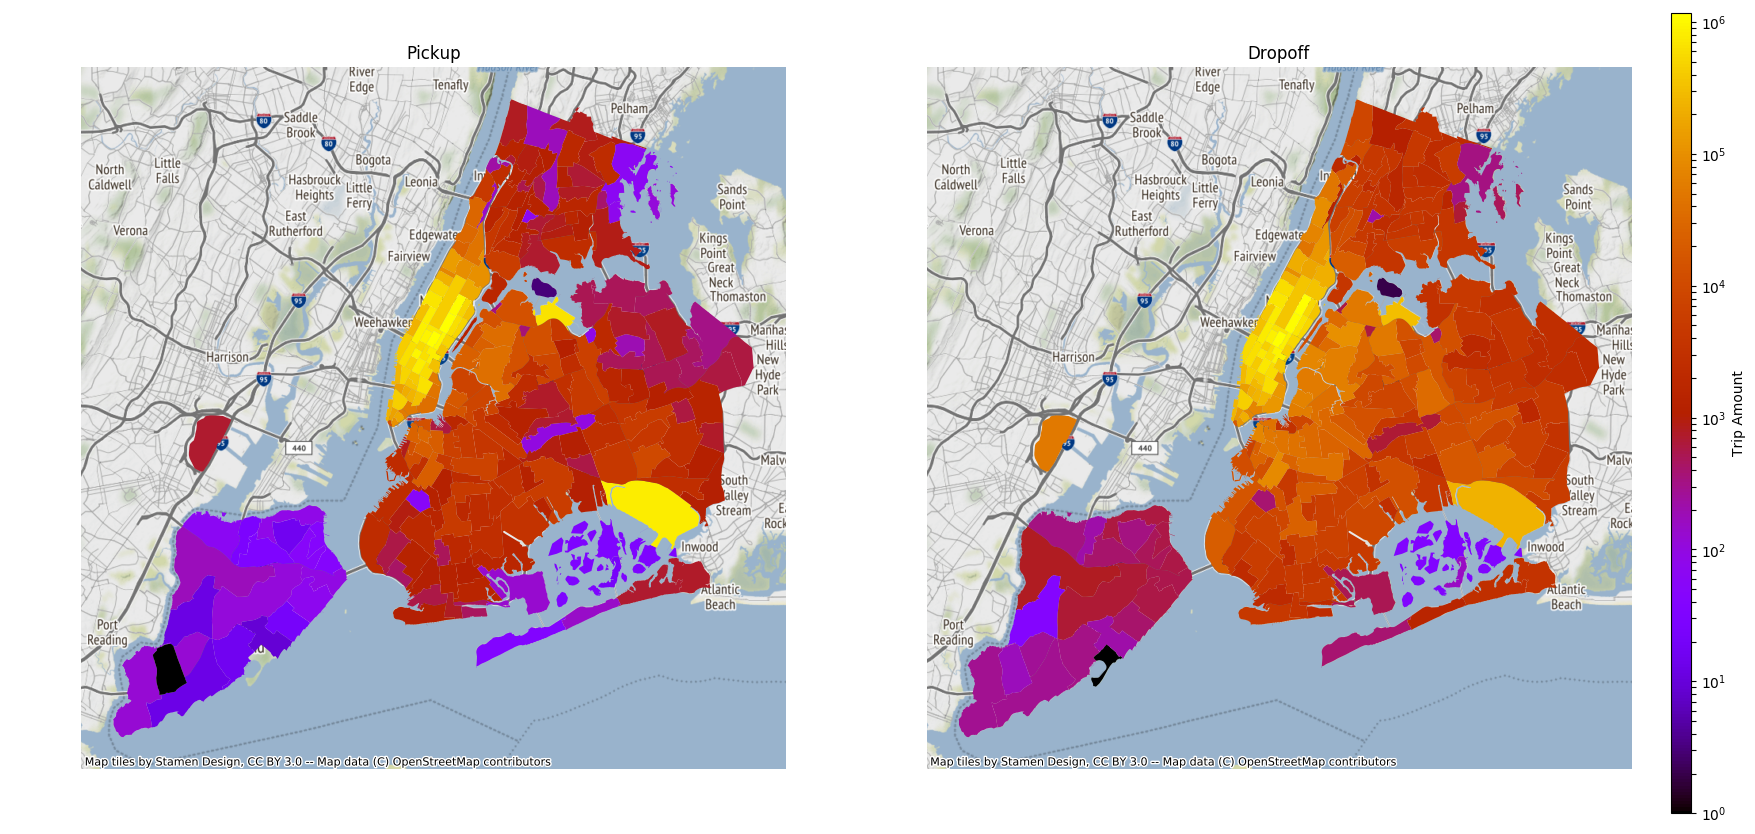

In [22]:
camp = 'gnuplot'

# plot geospatial visualisation to compare pickup and dropoff amount from each zone
fig, axs = plt.subplots(ncols=2, figsize=(20, 10), dpi=100)
# create a normalized colorbar
axs[0] = pick_up_zone.plot(column='size', 
                           figsize=(10, 10), 
                           norm=colors.LogNorm(vmin=pick_up_zone['size'].min(), 
                                               vmax=pick_up_zone['size'].max()), 
                           cmap=camp, 
                           ax=axs[0]) 
ctx.add_basemap(axs[0])
 
axs[1] = dorp_off_zone.plot(column='size', figsize=(10, 10), 
                            norm=colors.LogNorm(vmin=dorp_off_zone['size'].min(), 
                                                vmax=dorp_off_zone['size'].max()), 
                            cmap=camp, 
                            ax=axs[1])
ctx.add_basemap(axs[1])


axs[0].set_title('Pickup')
axs[1].set_title('Dropoff')
axs[0].set_axis_off()
axs[1].set_axis_off()

# draw the color bar
fig.colorbar(axs[1].collections[0],
             ax=axs[1], 
             orientation="vertical",
             cax=fig.add_axes([0.92, 0.1, 0.01, 0.8])).ax.set_ylabel('Trip Amount')

plt.show()

## weather

In [23]:
# get day right
nyc_temp = nyc_temp[((nyc_temp['date'] <= '2019-01-31')&
    (nyc_temp['date'] >= '2019-01-01'))|

    ((nyc_temp['date'] <= '2019-04-30')&
    (nyc_temp['date'] >= '2019-04-01'))|

    ((nyc_temp['date'] <= '2019-07-31')&
    (nyc_temp['date'] >= '2019-07-01'))|

    ((nyc_temp['date'] <= '2019-10-31')&
    (nyc_temp['date'] >= '2019-10-01'))]

In [24]:
tmp = nyc_temp[['date', 'tavg']]


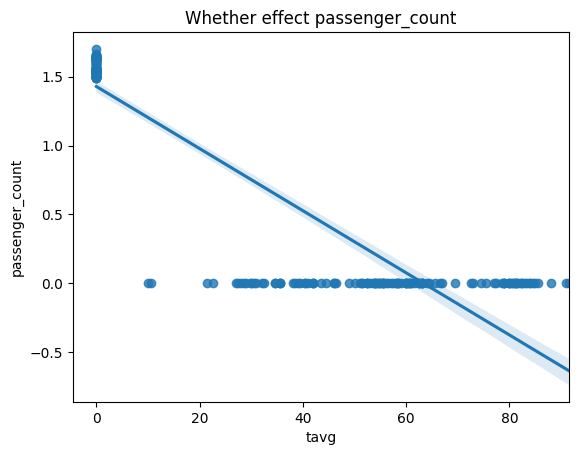

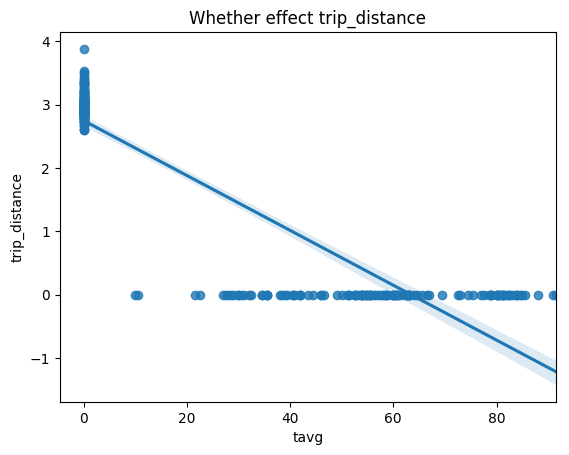

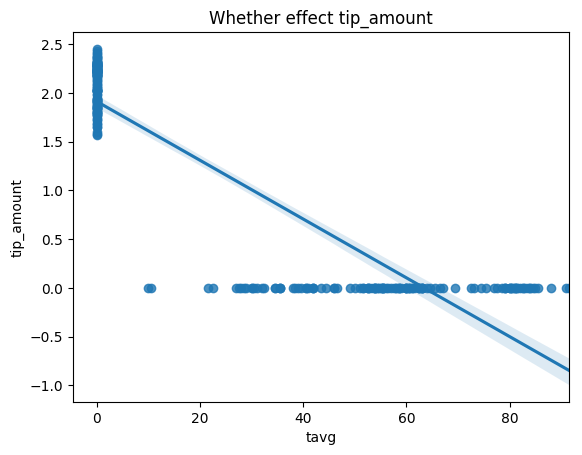

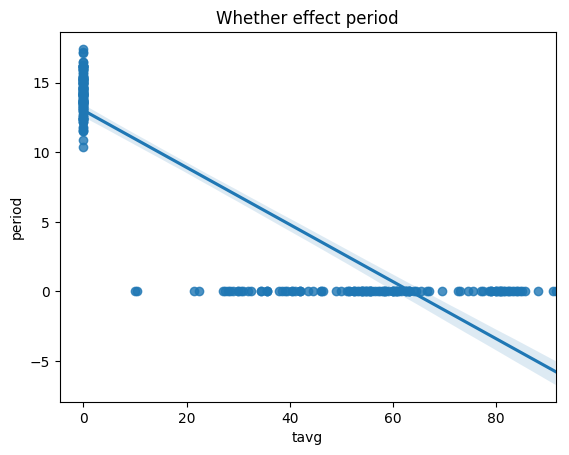

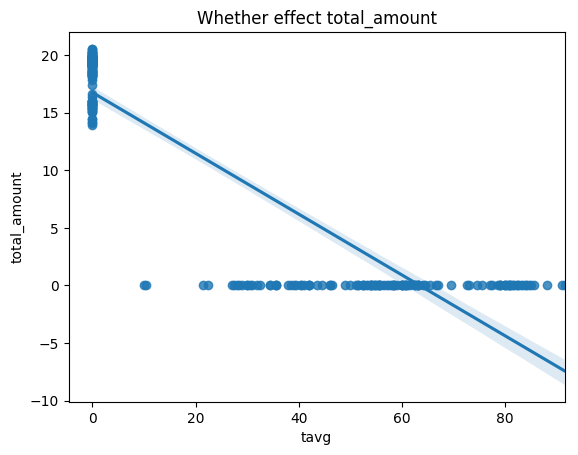

In [25]:

effect_col = ['passenger_count', 
                'trip_distance','tip_amount',
                'period', 'total_amount']


for ec in effect_col:
    t1 = data[['date_time', ec]].groupby(['date_time']).mean()
    
    result = pd.merge(tmp, t1, left_index=True, 
                    right_index=True, 
                    how='outer').fillna(0)

    plt.figure()
    sns.regplot(x="tavg", y=ec,  data=result)
    
    plt.title(f'Whether effect {ec}')
    plt.show()



## season affect

In [26]:
# get season

nyc_temp['season'] = 0
# get season
nyc_temp.loc[(nyc_temp['date'] <= '2019-01-31')& (nyc_temp['date'] >= '2019-01-01'), 'season'] = 'winter'
nyc_temp.loc[(nyc_temp['date'] <= '2019-04-30')& (nyc_temp['date'] >= '2019-04-01'), 'season'] = 'spring'
nyc_temp.loc[(nyc_temp['date'] <= '2019-07-31')& (nyc_temp['date'] >= '2019-07-01'), 'season'] = 'summer'
nyc_temp.loc[(nyc_temp['date'] <= '2019-10-31')& (nyc_temp['date'] >= '2019-10-01'), 'season'] = 'fall'

In [27]:
nyc_temp['precipitation'] = nyc_temp['precipitation'].astype('float16')
nyc_temp['new_snow'] = nyc_temp['new_snow'].astype('float16')
nyc_temp['snow_depth'] = nyc_temp['snow_depth'].astype('float16')

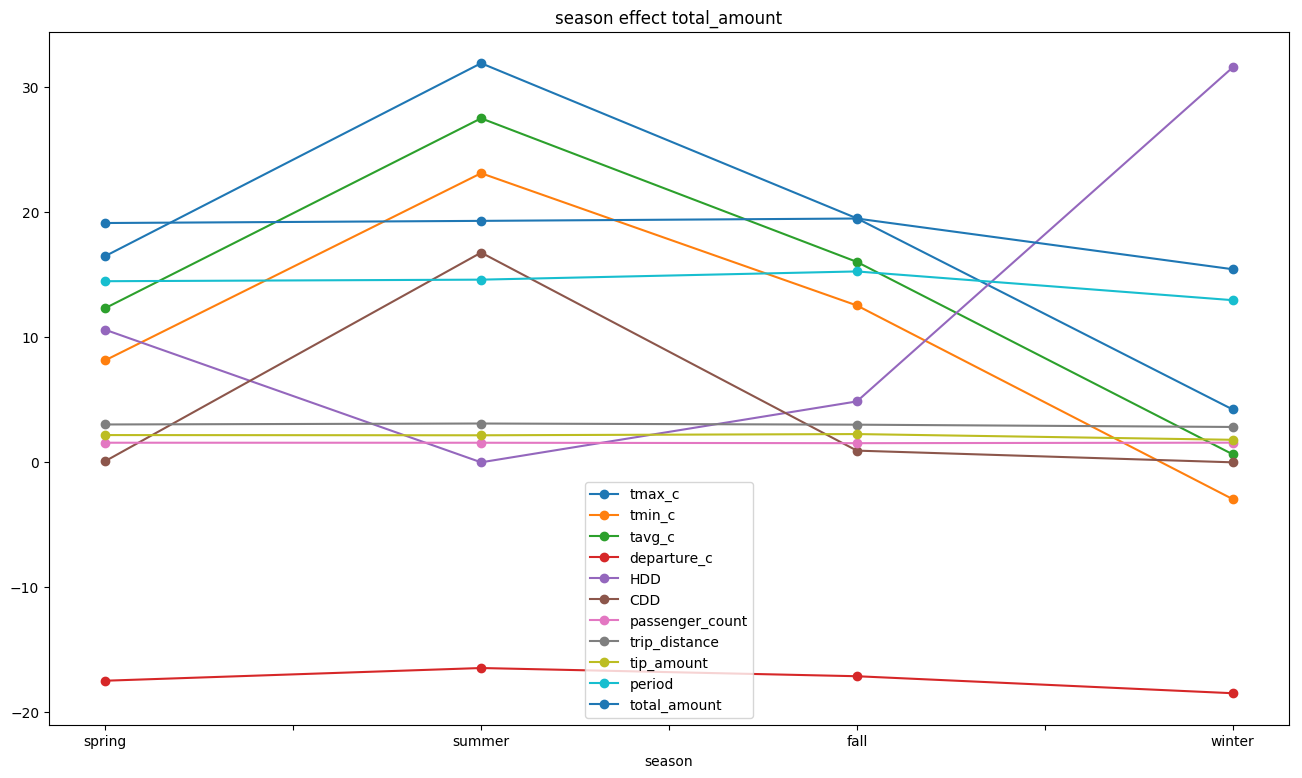

In [28]:

effect_col = ['passenger_count', 
                'trip_distance','tip_amount',
                'period', 'total_amount']

d1 = nyc_temp[['season', 'tmax_c', 'tmin_c', 'tavg_c', 'departure_c', 'HDD', 'CDD']].groupby(['season']).mean()
for ec in effect_col:
    t1 = data[['season', ec]].groupby(['season']).mean()

    d1 = pd.merge(d1, t1, left_on='season', 
                    right_on='season', 
                    how='outer')
    

d1.loc[['spring', 'summer', 'fall', 'winter']].plot(marker='o', figsize=(16, 9),title=f'season effect {ec}')
plt.show()
    

# Model

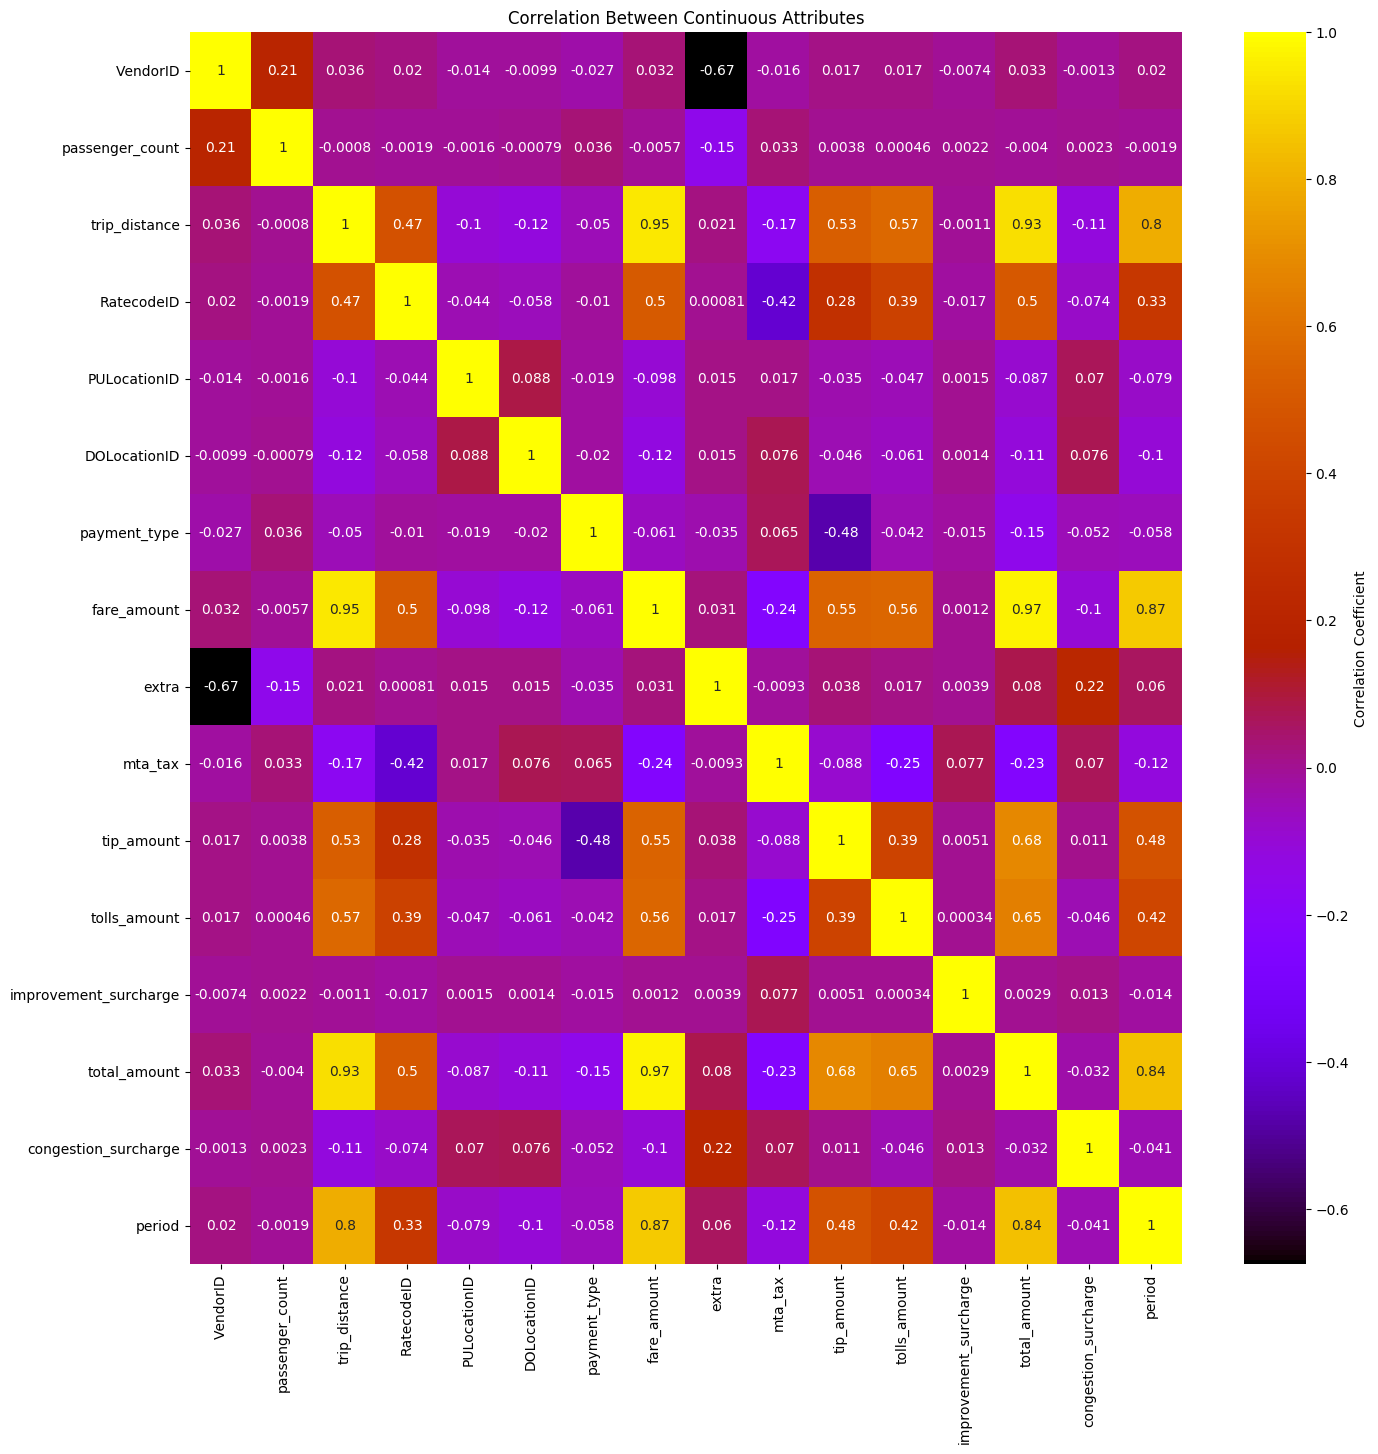

In [30]:
# plot correlation plot
fig, ax = plt.subplots(figsize=(16, 16), dpi=100)
sns.heatmap(data.corr(), annot=True, ax=ax, cmap=camp,
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Between Continuous Attributes")
plt.show()

In [48]:
y = data['total_amount']
X = data[['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'period']]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [50]:
# define standard scaler
scaler = StandardScaler()
# transform data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## LinearRegression

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred_train_lr= lr.predict(X_train)
print(f'Linear Regression Model train set RMSE{np.sqrt(mean_squared_error(y_train,pred_train_lr))}')
print(f'Linear Regression ModelR-square {r2_score(y_train, pred_train_lr)}')

pred_test_lr= lr.predict(X_test)
print(f'Linear Regression Model test set RMSE{np.sqrt(mean_squared_error(y_test,pred_test_lr))}') 
print(f'Linear Regression Model test set R-square {r2_score(y_test, pred_test_lr)}')

Linear Regression Model train set RMSE1.2509554851450793
Linear Regression ModelR-square 1.0
Linear Regression Model test set RMSE1.2505774549590287
Linear Regression Model test set R-square 1.0


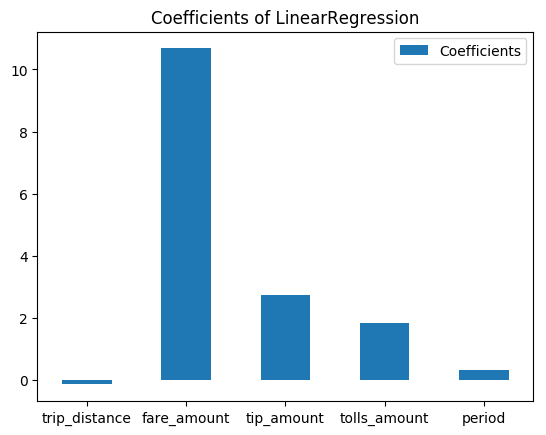

In [53]:
# coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
# coefficients
coefficients = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficients'])
coefficients.plot(kind='bar', rot=0, title='Coefficients of LinearRegression')
plt.show()

## Ridge

In [55]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(f'Ridge Regression Model train set RMSE: {np.sqrt(mean_squared_error(y_train,pred_train_rr))}')
print(f'Ridge Regression ModelR-square: {r2_score(y_train, pred_train_rr)}')

pred_test_rr= rr.predict(X_test)
print(f'Ridge Regression Model test set RMSE: {np.sqrt(mean_squared_error(y_test,pred_test_rr))}') 
print(f'Ridge Regression Model test set R-square: {r2_score(y_test, pred_test_rr)}')

Ridge Regression Model train set RMSE1.2509554851450795
Ridge Regression ModelR-square 1.0
Ridge Regression Model test set RMSE1.2505774549278643
Ridge Regression Model test set R-square 1.0


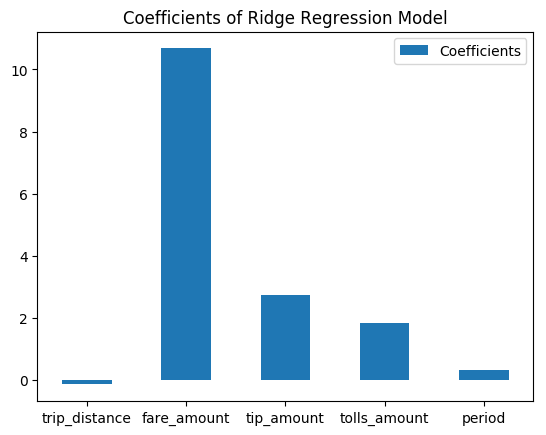

In [56]:
coefficients = pd.DataFrame(rr.coef_, X.columns, columns=['Coefficients'])
coefficients.plot(kind='bar', rot=0, title='Coefficients of Ridge Regression Model')
plt.show()

## Lasso

In [59]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print(f'lasso Regression Model train set RMSE: {np.sqrt(mean_squared_error(y_train,pred_train_lasso))}')
print(f'lasso Regression ModelR-square: {r2_score(y_train, pred_train_lasso)}')

pred_test_lasso= model_lasso.predict(X_test)
print(f'lasso Regression Model test set RMSE: {np.sqrt(mean_squared_error(y_test,pred_test_lasso))}') 
print(f'lasso Regression Model test set R-square: {r2_score(y_test, pred_test_lasso)}')

lasso Regression Model train set RMSE: 1.2517365898367934
lasso Regression ModelR-square: 1.0
lasso Regression Model test set RMSE: 1.251341417743324
lasso Regression Model test set R-square: 1.0


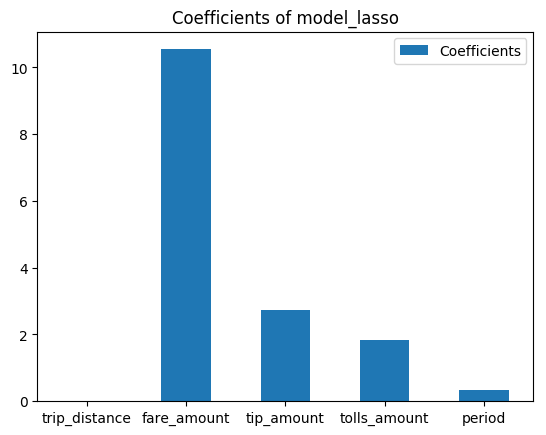

In [60]:
coefficients = pd.DataFrame(model_lasso.coef_, X.columns, columns=['Coefficients'])
coefficients.plot(kind='bar', rot=0, title='Coefficients of model_lasso')
plt.show()